In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
plt.rc("font", family = "MicroSoft YaHei", weight = "bold") # 防止中文乱码

#### 简单起见只考虑解
$$
\frac{1}{2}||y-x\beta||^2+\mu||\beta||_{1,2}
$$
#### 的问题，其中$\beta$是一维向量，解法是采用近似点梯度（可能先实现次梯度下降，效率不重要）

#### 相关系数聚类算法

In [398]:
def cor_means(k,x):
    dic = {}
    cls = {}
    for i in range(k):
        dic[i] = x[:,2*i]
        cls[i] = []
    it = 0
    while it < 10:
        for i in range(k):
            cls[i] = []
        for j in range(x.shape[1]):
            corr = [pd.Series(x[:,j]).corr(pd.Series(dic[i])) for i in range(k)]
            for s in range(k):
                if corr[s] == max(corr):
                    cls[s].append(j)
        for i in range(k):
            new_i = x[:,cls[i][0]]
            for j in range(1,len(cls[i])):
                new_i += x[:,cls[i][j]]
            dic[i] = new_i/np.linalg.norm(new_i,ord=2)
        it += 1
    corr = [pd.Series(x[:,3]).corr(pd.Series(dic[i])) for i in range(k)]
    #print(corr)
    return cls

#### 根据相关系数聚类得到分组

In [404]:
def find_div(k,x,beta):
    dic = cor_means(k,x)
    beta_new = np.zeros(beta.shape)
    x_new = np.zeros(x.shape)
    j = 0
    kk = 0
    div = []
    while j < x.shape[1]:
        s = len(dic[kk])
        beta_new[j:j+s] = beta[dic[kk]].copy()
        x_new[j:j+s,:] = x[dic[kk],:].copy()
        div.append([j,j+s])
        j += s
        kk += 1
    return x_new,beta_new,div

#### 关于给定分组的组LASSO的次梯度下降算法

In [432]:
#定义求值的函数
def f(y,x,beta,mu,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+mu*g(beta,div)

def g(beta,div):
    s = 0
    for dd in div:
        s += np.linalg.norm(beta[dd[0]:dd[1]],ord=2)
    return s

def subgradient(beta,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
    return sub

def sub_dec(x,y,mu,beta0,div):
    k = 0
    t = 1e-5
    beta = beta0.copy()
    val = [f(y,x,beta,mu,div)]
    bb = [beta]

    while k < 100000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+mu*subgradient(beta,div))
        ff = f(y,x,beta,mu,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

#### Elastic Net的次梯度下降算法，传入分组为单个分组

In [431]:
#定义求值的函数
def e_f(y,x,beta,mu1,mu2,div):
    return 0.5*np.linalg.norm(y-np.dot(x,beta), ord=2)**2+e_g(beta,mu1,mu2,div)

def e_g(beta,mu1,mu2,div):
    s = 0
    for dd in div:
        s += mu1*np.linalg.norm(beta[dd[0]:dd[1]],ord=2)**2+mu2*np.linalg.norm(beta[dd[0]:dd[1]],ord=1)
    return s

def e_subgradient(beta,mu1,mu2,div):
    sub = np.zeros(beta.shape)
    for dd in div:
        if np.linalg.norm(beta[dd[0]:dd[1]])>0:
            sub[dd[0]:dd[1]] = mu1*beta[dd[0]:dd[1]]/np.linalg.norm(beta[dd[0]:dd[1]])
            for i in range(dd[0],dd[1]):
                if sub[i] > 0:
                    sub[i] += mu2
                else:
                    sub[i] -= mu2
    return sub

def elastic(x,y,mu1,mu2,beta0,div):
    k = 0
    t = 1e-5
    beta = beta0.copy()
    val = [e_f(y,x,beta,mu1,mu2,div)]
    bb = [beta]

    while k < 100000:
        beta -= t*(np.dot(x.T,np.dot(x,beta)-y)+e_subgradient(beta,mu1,mu2,div))
        ff = e_f(y,x,beta,mu1,mu2,div)
        if abs(ff-val[-1]) < 1e-10:
            break
        val.append(ff)
        bb.append(beta)
        k += 1
        #t /= (k+1)/k
    return beta,val

def sparsity(beta):
    return np.sum(abs(beta)>1e-4*np.sum(abs(beta)))/len(beta)

#### 生成数据，组内高度相关

In [405]:
p = 20 #beta的维度
n = 100 #样本个数

#初始化真实的beta
beta = np.random.randn(p)
div = [[2*i,2*i+2] for i in range(p//2)] #分组方式
for i in range(p//2):
    if i%2 == 0:
        beta[div[i][0]:div[i][1]] = 0
x = np.zeros([n,p])
for i in range(p//2):
    x[:,2*i] = np.random.randn(n).T
    x[:,2*i+1] = x[:,2*i]*2+2*np.random.randn(n).T
y = np.dot(x,beta)
y += 0.01*np.random.randn(n)

k = p//2
x_new,beta_new,div_new = find_div(k,x,beta)
y_new = np.dot(x_new,beta_new)
y_new += 0.01*np.random.randn(n)


#### 根据分组求解组LASSO

In [451]:
beta0 = np.random.rand(p)
mu = 1
beta_div,val_div = sub_dec(x_new,y_new,mu,beta0,div_new)

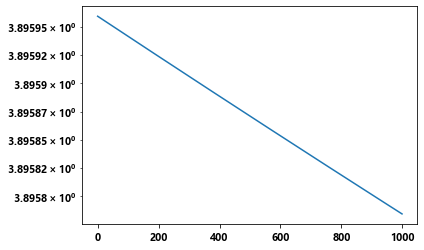

beta         [ 0.          0.         -0.88684267 -0.20741299  0.          0.
 -0.48101388  0.05068348  0.          0.          0.82610367  2.04852993
  0.          0.         -0.60316996  2.32803517  0.          0.
  0.49167451  0.77935243]
beta_div     [ 1.92257329e-03  1.49940775e-04 -9.07186439e-01 -3.37328932e-02
 -1.17575534e-03 -2.03286845e-04 -4.67885021e-01 -3.19936421e-02
 -3.12567411e-03 -2.37147858e-04  1.00473705e+00  1.80727708e-01
 -6.50417237e-03 -3.96342172e-04 -3.88450607e-01  1.18454715e-01
  1.20656836e-03  4.98883202e-05  5.62087828e-01  4.75494810e-02]


In [452]:
plt.semilogy(val_div[-1000:])
plt.show()
print('beta        ',beta_new)
print('beta_div    ',beta_div)

In [453]:
print(f(y_new,x_new,beta_div,mu,div_new))
print(f(y_new,x_new,beta_new,mu,div_new))

3.8957845926099184
6.9350734519078685


#### 使用Elastic Net求解

In [448]:
div_e = [[i,i+1] for i in range(p)]
beta_ela,val_ela = elastic(x_new,y_new,0.5*mu,0.5*mu,beta0,div_e)

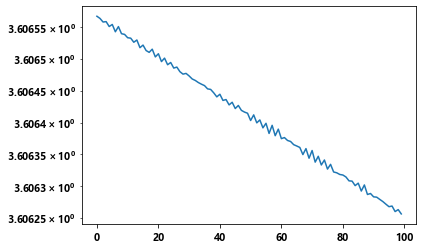

beta         [ 0.          0.         -0.88684267 -0.20741299  0.          0.
 -0.48101388  0.05068348  0.          0.          0.82610367  2.04852993
  0.          0.         -0.60316996  2.32803517  0.          0.
  0.49167451  0.77935243]
beta_ela     [ 2.01869744e-03  3.37673551e-06 -9.10579894e-01 -9.61033792e-06
 -1.25487105e-03  4.94330250e-06 -4.70738072e-01 -7.62050263e-06
 -3.27424874e-03 -1.20999172e-06  1.00279931e+00  1.99460857e-01
 -6.91736213e-03  2.08158087e-06 -3.76871635e-01  6.85980902e-06
  1.28217277e-03  9.09001025e-06  5.66796144e-01 -3.67476654e-06]


In [449]:
plt.semilogy(val_ela[-100:])
plt.show()
print('beta        ',beta_new)
print('beta_ela    ',beta_ela)

In [450]:
print(e_f(y_new,x_new,beta_ela,0.5*mu,0.5*mu,div_e))
print(e_f(y_new,x_new,beta_new,0.5*mu,0.5*mu,div_e))

3.6062565915225284
10.644350639227584
